In [4]:
# from google.colab import drive
# drive.mount('/content/gdrive')

In [5]:
categories_to_use = ['n01443537', 'n07734744', 'n09193705', 'n02099601', 'n02486410', 'n02124075', 'n01768244', 'n01944390', 'n02988304']

names_of_categories = ['goldfish', 'mushroom', 'alp', 'golden retriever', 'baboon', 'Egyptian cat', 'trilobite', 'snail', 'CD player']

In [6]:
import numpy as np
from PIL import Image
from numpy import asarray
import os

images = []
labels = []
for x in categories_to_use:
  count_per_category = 0
  for y in os.listdir("tiny-imagenet-200/train/" + x + "/images"):
      img = Image.open("tiny-imagenet-200/train/" + x + "/images/" + y)
      img = img.convert("RGB")
      numpydata = asarray(img)
      numpydata = np.expand_dims(numpydata, axis=0)
      images.append(numpydata)
      labels.append(x)
      count_per_category += 1
      if count_per_category >= 250: break

count_per_category = 0
for y in os.listdir("tiny-imagenet-200/test/images"):
  img = Image.open("tiny-imagenet-200/test/images/" + y)
  img = img.convert("RGB")
  numpydata = asarray(img)
  numpydata = np.expand_dims(numpydata, axis=0)
  images.append(numpydata)
  labels.append("Not correct answer")
  count_per_category += 1
  if count_per_category >= 250: break

print(len(images))
print(len(labels))

images = images[0:5000]
labels = labels[0:5000]

2500
2500


In [28]:
val_images =[]
val_labels = []
file_names = [] #for debugging
for i in range(0, 10000):
  img = Image.open("tiny-imagenet-200/val/images/val_" + str(i) + ".JPEG")
  img = img.convert("RGB")
  numpydata = asarray(img)
  numpydata = np.expand_dims(numpydata, axis=0)
  val_images.append(numpydata)
  file_names.append(i)

f = open("tiny-imagenet-200/val/val_annotations.txt", "r")
for x in f:
  val_labels.append("n" + x.split('n', 1)[1][0:8])
f.close()

file_names = [file_names[i] for i in range(0, len(val_labels)) if val_labels[i] in categories_to_use]
val_images = [val_images[i] for i in range(0, len(val_labels)) if val_labels[i] in categories_to_use]
val_labels = [val_labels[i] for i in range(0, len(val_labels)) if val_labels[i] in categories_to_use]

print(len(val_images))
print(len(val_labels))

#add in non categories
count_per_category = 0
reversed = os.listdir("tiny-imagenet-200/test/images")
reversed.reverse()
for y in reversed:
  img = Image.open("tiny-imagenet-200/test/images/" + y)
  img = img.convert("RGB")
  numpydata = asarray(img)
  numpydata = np.expand_dims(numpydata, axis=0)
  val_images.append(numpydata)
  val_labels.append("Not correct answer")
  count_per_category += 1
  if count_per_category >= 800: break

print(len(val_images))
print(len(val_labels))

val_images = val_images[0:3000]
val_labels = val_labels[0:3000]

450
450
1250
1250


(64, 64, 3)
36


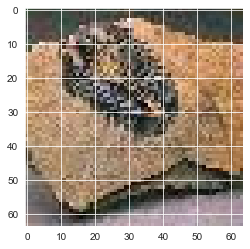

In [8]:
import matplotlib.pyplot as plt

def display_image(image):
  displayable_image = np.squeeze(image, axis=0)
  plt.imshow(displayable_image)
  plt.show
  print(displayable_image.shape)

display_image(val_images[0])
print(file_names[0])

In [9]:
from keras.applications.vgg16 import VGG16
import tensorflow as tf

base_model = tf.keras.applications.vgg19.VGG19(weights=None, include_top=False, input_shape=(64,64,3))
base_model.summary()

2022-07-27 18:07:56.350952: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 64, 64, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 64, 64, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 32, 32, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 32, 32, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 32, 32, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 16, 16, 128)       0     

In [10]:
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import sklearn
import seaborn as sns

def load_batches(batches, amount_to_include=-1):
  final_labels = []
  final_images = []
  for batch in batches:
    file_1 = np.load(batch, allow_pickle=True)
    images = file_1["data"].reshape(-1  , 3 , 32 , 32)
    images = images.transpose(0 , -2 , -1 , 1)

    labels = file_1["labels"]

    resized = []
    for i in range(0, len(images)):
      resized.append(np.expand_dims(images[i], axis=0))
    images = resized

    for i in range(0, len(images)):
      final_images.append(images[i])
    for i in range(0, len(labels)):
      final_labels.append(labels[i])
  
  if amount_to_include == -1:
    return final_images, final_labels
  else:
    return final_images[0:amount_to_include], final_labels[0:amount_to_include]

Correct labels: https://gist.github.com/aaronpolhamus/964a4411c0906315deb9f4a3723aac57

In [11]:
from keras import backend as K
from tqdm.notebook import tqdm

# def turn_image_data_into_layer_outputs(image_data):
#   inp = base_model.input
#   outputs = [layer.output for layer in base_model.layers]
#   functors = [K.function([inp], [out]) for out in outputs]
#   new_input = []
#   print(len(image_data))
#   for i in tqdm(range(0, len(image_data))): #set to len(image_data)
#     new_input.append([func([image_data[i]]) for func in functors])
#   return new_input

import pickle

from keras.models import Model
# intermediate_layer_model = Model(inputs=base_model.input,
#                                  outputs=[base_model.get_layer("block1_conv1").output,
#                                  base_model.get_layer("block1_conv1").output])
intermediate_layer_model = Model(inputs=base_model.input,
                                 outputs=[base_model.layers[i].output for i in range(0,len(base_model.layers))])
def turn_image_data_into_layer_outputs(image_data):
  new_input = []
  for i in tqdm(range(0, len(image_data))):
    new_input.append(intermediate_layer_model.predict(image_data[i]))
  return new_input

# def turn_image_data_into_layer_outputs(image_data):
#   inp = base_model.input
#   outputs = [layer.output for layer in base_model.layers]
#   functor = K.function([inp, K.learning_phase()], outputs )
#   new_input = []
#   for i in tqdm(range(0, len(image_data))):
#     new_input.append(functor([image_data[i], 1.]))
#   return new_input

In [12]:
def get_one_layer_output(layer_num, all_layers_output): #add a non-cache option
  layer_output = []
  for i in range(0, len(all_layers_output)):

    train_dataset = all_layers_output[i][layer_num]
    d2_train_dataset = train_dataset.reshape(-1)

    layer_output.append(d2_train_dataset)
  return layer_output

def get_one_layer_output_no_cache(layer_num, image_data): #add a non-cache option
  intermediate_layer_model = Model(inputs=base_model.input,
                                   outputs=[base_model.layers[layer_num].output])
  layer_output = []
  for i in range(0, len(image_data)):
    out = intermediate_layer_model.predict(image_data[i])
    out2 = []
    for list in out:
      out2 = [*out2, *list.flatten()]
    layer_output.append(out2)
  return layer_output

def get_true_or_false_array(category_num, labels):
  output = []
  for i in range(0, len(labels)):  #set to len(image_data)
    if labels[i] == category_num:
      output.append(1)
    else:
      output.append(0)
  return output

(64, 64, 3)
(1, 64, 64, 3)


  0%|          | 0/2500 [00:00<?, ?it/s]

1/1 [==============================] - 0s 45ms/step


  0%|          | 0/1250 [00:00<?, ?it/s]

1/1 [==============================] - 0s 42ms/step


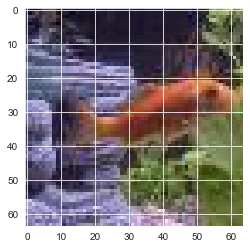

In [13]:
# images, labels = load_batches(["Imagenet32_train/train_data_batch_1",
#                                "Imagenet32_train/train_data_batch_2",
#                                "Imagenet32_train/train_data_batch_3",
#                                "Imagenet32_train/train_data_batch_4",
#                                "Imagenet32_train/train_data_batch_5",
#                                "Imagenet32_train/train_data_batch_6",
#                                "Imagenet32_train/train_data_batch_7",
#                                "Imagenet32_train/train_data_batch_8",
#                                "Imagenet32_train/train_data_batch_9",])
# val_images, val_labels = load_batches(["val_data"])

display_image(val_images[1])

print(val_images[1].shape)

import pickle

all_layers_out = turn_image_data_into_layer_outputs(images)

# with open('all_layers_out.pkl', 'wb') as f:
#   pickle.dump(all_layers_out, f)

val_all_layers_out = turn_image_data_into_layer_outputs(val_images)

# with open('val_all_layers_out.pkl', 'wb') as f:
#   pickle.dump(val_all_layers_out, f)

# print(all_layers_out[0][0][0].flatten())

# log_input = get_one_layer_output(1, all_layers_out)
# print(log_input)
# log_output = get_true_or_false_array(1, labels)
# print(log_output)

# print(len(log_input))
# print(len(log_output))

In [14]:
# print(get_one_layer_output_no_cache(0, val_images))

In [15]:
# print(get_one_layer_output(0, val_all_layers_out))

In [16]:
# for i in range(0, 100):
#   labels[i] = 993

print(labels)
print(val_labels)

def most_common(lst):
  return max(set(lst), key=lst.count)
print(most_common(labels))
print(most_common(val_labels))

['n01443537', 'n01443537', 'n01443537', 'n01443537', 'n01443537', 'n01443537', 'n01443537', 'n01443537', 'n01443537', 'n01443537', 'n01443537', 'n01443537', 'n01443537', 'n01443537', 'n01443537', 'n01443537', 'n01443537', 'n01443537', 'n01443537', 'n01443537', 'n01443537', 'n01443537', 'n01443537', 'n01443537', 'n01443537', 'n01443537', 'n01443537', 'n01443537', 'n01443537', 'n01443537', 'n01443537', 'n01443537', 'n01443537', 'n01443537', 'n01443537', 'n01443537', 'n01443537', 'n01443537', 'n01443537', 'n01443537', 'n01443537', 'n01443537', 'n01443537', 'n01443537', 'n01443537', 'n01443537', 'n01443537', 'n01443537', 'n01443537', 'n01443537', 'n01443537', 'n01443537', 'n01443537', 'n01443537', 'n01443537', 'n01443537', 'n01443537', 'n01443537', 'n01443537', 'n01443537', 'n01443537', 'n01443537', 'n01443537', 'n01443537', 'n01443537', 'n01443537', 'n01443537', 'n01443537', 'n01443537', 'n01443537', 'n01443537', 'n01443537', 'n01443537', 'n01443537', 'n01443537', 'n01443537', 'n01443537'

In [17]:
accuracy_data = {}

In [18]:
def list_similarity(list1, list2):
  count = 0
  for i in range(0, len(list1)):
    if list1[i] == list2[i]:
      count += 1
  return count / len(list1)

def calculate_accuracy_array():
  #accuracy_data = np.zeros((1000, 22))
  for cat in tqdm(categories_to_use):
    accuracy_data[cat] = []
    for lay in tqdm(range(0, 22)):

      log_input = get_one_layer_output(lay, all_layers_out)
      # print(log_input)
      #log_input = get_one_layer_output_no_cache(lay, images)

      log_output = get_true_or_false_array(cat, labels)
      # print(log_output)

      print("started")
      logisticRegression = sklearn.linear_model.LogisticRegression(solver='liblinear', random_state=0)
      logisticRegression.fit(log_input, log_output)
      print("ended")
      
      val_log_input = get_one_layer_output(lay, val_all_layers_out)
      #val_log_input = get_one_layer_output_no_cache(lay, val_images)

      print("started")
      val_log_output = logisticRegression.predict(val_log_input)
      print("ended")
      true_val_log_output = get_true_or_false_array(cat, val_labels)

      accuracy_data[cat].append(list_similarity(true_val_log_output, val_log_output))

calculate_accuracy_array()

with open('accuracy_data.pkl', 'wb') as f:
  pickle.dump(accuracy_data, f)

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

started
ended
started
ended
started
ended
started
ended
started
ended
started
ended
started
ended
started
ended
started
ended
started
ended
started
ended
started
ended
started
ended
started
ended
started
ended
started
ended
started
ended
started
ended
started
ended
started
ended
started
ended
started
ended
started
ended
started
ended
started
ended
started
ended
started
ended
started
ended
started
ended
started
ended
started
ended
started
ended
started
ended
started
ended
started
ended
started
ended
started
ended
started
ended
started
ended
started
ended
started
ended
started
ended
started
ended
started
ended


  0%|          | 0/22 [00:00<?, ?it/s]

started
ended
started
ended
started
ended
started
ended
started
ended
started
ended
started
ended
started
ended
started
ended
started
ended
started
ended
started
ended
started
ended
started
ended
started
ended
started
ended
started
ended
started
ended
started
ended
started
ended
started
ended
started
ended
started
ended
started
ended
started
ended
started
ended
started
ended
started
ended
started
ended
started
ended
started
ended
started
ended
started
ended
started
ended
started
ended
started
ended
started
ended
started
ended
started
ended
started
ended
started
ended
started
ended
started
ended
started
ended


  0%|          | 0/22 [00:00<?, ?it/s]

started
ended
started
ended
started
ended
started
ended
started
ended
started
ended
started
ended
started
ended
started
ended
started
ended
started
ended
started
ended
started
ended
started
ended
started
ended
started
ended
started
ended
started
ended
started
ended
started
ended
started
ended
started
ended
started
ended
started
ended
started
ended
started
ended
started
ended
started
ended
started
ended
started
ended
started
ended
started
ended
started
ended
started
ended
started
ended
started
ended
started
ended
started
ended
started
ended
started
ended
started
ended
started
ended
started
ended
started
ended


  0%|          | 0/22 [00:00<?, ?it/s]

started
ended
started
ended
started
ended
started
ended
started
ended
started
ended
started
ended
started
ended
started
ended
started
ended
started
ended
started
ended
started
ended
started
ended
started
ended
started
ended
started
ended
started
ended
started
ended
started
ended
started
ended
started
ended
started
ended
started
ended
started
ended
started
ended
started
ended
started
ended
started
ended
started
ended
started
ended
started
ended
started
ended
started
ended
started
ended
started
ended
started
ended
started
ended
started
ended
started
ended
started
ended
started
ended
started
ended
started
ended


  0%|          | 0/22 [00:00<?, ?it/s]

started
ended
started
ended
started
ended
started
ended
started
ended
started
ended
started
ended
started
ended
started
ended
started
ended
started
ended
started
ended
started
ended
started
ended
started
ended
started
ended
started
ended
started
ended
started
ended
started
ended
started
ended
started
ended
started
ended
started
ended
started
ended
started
ended
started
ended
started
ended
started
ended
started
ended
started
ended
started
ended
started
ended
started
ended
started
ended
started
ended
started
ended
started
ended
started
ended
started
ended
started
ended
started
ended
started
ended
started
ended


  0%|          | 0/22 [00:00<?, ?it/s]

started
ended
started
ended
started
ended
started
ended
started
ended
started
ended
started
ended
started
ended
started
ended
started
ended
started
ended
started
ended
started
ended
started
ended
started
ended
started
ended
started
ended
started
ended
started
ended
started
ended
started
ended
started
ended
started
ended
started
ended
started
ended
started
ended
started
ended
started
ended
started
ended
started
ended
started
ended
started
ended
started
ended
started
ended
started
ended
started
ended
started
ended
started
ended
started
ended
started
ended
started
ended
started
ended
started
ended
started
ended


  0%|          | 0/22 [00:00<?, ?it/s]

started
ended
started
ended
started
ended
started
ended
started
ended
started
ended
started
ended
started
ended
started
ended
started
ended
started
ended
started
ended
started
ended
started
ended
started
ended
started
ended
started
ended
started
ended
started
ended
started
ended
started
ended
started
ended
started
ended
started
ended
started
ended
started
ended
started
ended
started
ended
started
ended
started
ended
started
ended
started
ended
started
ended
started
ended
started
ended
started
ended
started
ended
started
ended
started
ended
started
ended
started
ended
started
ended
started
ended
started
ended


  0%|          | 0/22 [00:00<?, ?it/s]

started
ended
started
ended
started
ended
started
ended
started
ended
started
ended
started
ended
started
ended
started
ended
started
ended
started
ended
started
ended
started
ended
started
ended
started
ended
started
ended
started
ended
started
ended
started
ended
started
ended
started
ended
started
ended
started
ended
started
ended
started
ended
started
ended
started
ended
started
ended
started
ended
started
ended
started
ended
started
ended
started
ended
started
ended
started
ended
started
ended
started
ended
started
ended
started
ended
started
ended
started
ended
started
ended
started
ended
started
ended


  0%|          | 0/22 [00:00<?, ?it/s]

started
ended
started
ended
started
ended
started
ended
started
ended
started
ended
started
ended
started
ended
started
ended
started
ended
started
ended
started
ended
started
ended
started
ended
started
ended
started
ended
started
ended
started
ended
started
ended
started
ended
started
ended
started
ended
started
ended
started
ended
started
ended
started
ended
started
ended
started
ended
started
ended
started
ended
started
ended
started
ended
started
ended
started
ended
started
ended
started
ended
started
ended
started
ended
started
ended
started
ended
started
ended
started
ended
started
ended
started
ended


In [19]:
import pickle
with open('accuracy_data.pkl', 'rb') as pickle_file:
  accuracy_data = pickle.load(pickle_file)

In [26]:
# count = 0
# for iy, ix in np.ndindex(array.shape):
#   if array[iy, ix] != 0:
#     count += 1
#     print(str(iy) + ", " + str(ix) + ": " + str(array[iy, ix]))
# print(count)
heatmap_data = []
for x in categories_to_use:
  print(accuracy_data[x])
  heatmap_data.append(accuracy_data[x])

mk = 0
for x in range(0, len(heatmap_data)):
  for y in range(0, len(heatmap_data[x])):
    if heatmap_data[x][y] > mk: mk = heatmap_data[x][y]
print(mk)

[0.8656, 0.9496, 0.948, 0.952, 0.9544, 0.9544, 0.956, 0.9592, 0.956, 0.9552, 0.9576, 0.9608, 0.96, 0.964, 0.9656, 0.964, 0.9632, 0.9632, 0.9648, 0.9656, 0.9648, 0.9624]
[0.9104, 0.9296, 0.932, 0.9256, 0.9352, 0.9392, 0.9376, 0.9472, 0.9464, 0.9488, 0.944, 0.9448, 0.9472, 0.9472, 0.9536, 0.9496, 0.9552, 0.9496, 0.9552, 0.9568, 0.96, 0.96]
[0.8928, 0.9328, 0.9288, 0.9288, 0.9344, 0.932, 0.9312, 0.9304, 0.9304, 0.9288, 0.9312, 0.932, 0.9296, 0.9336, 0.9336, 0.9328, 0.932, 0.9328, 0.9336, 0.9344, 0.9424, 0.952]
[0.8216, 0.9272, 0.9328, 0.9264, 0.9344, 0.9304, 0.94, 0.9416, 0.9392, 0.94, 0.9424, 0.9416, 0.9448, 0.9416, 0.9424, 0.9488, 0.9504, 0.9544, 0.956, 0.9584, 0.9592, 0.96]
[0.8728, 0.9288, 0.9352, 0.9344, 0.94, 0.9432, 0.948, 0.94, 0.9448, 0.9448, 0.944, 0.9416, 0.9384, 0.9424, 0.9336, 0.9384, 0.9432, 0.9504, 0.96, 0.9616, 0.96, 0.96]
[0.868, 0.9096, 0.92, 0.924, 0.9296, 0.9368, 0.9304, 0.9336, 0.9328, 0.9376, 0.9376, 0.944, 0.9384, 0.9408, 0.9448, 0.952, 0.9496, 0.9552, 0.9576, 0.96,

['a_0.JPEG', 'a_1.JPEG', 'a_2.JPEG', 'b_0.JPEG', 'b_1.JPEG', 'b_2.JPEG', 'c_0.JPEG', 'c_1.JPEG', 'c_2.JPEG', 'd_0.JPEG', 'd_1.JPEG', 'd_2.JPEG', 'e_0.JPEG', 'e_1.JPEG', 'e_2.JPEG', 'f_0.JPEG', 'f_1.JPEG', 'f_2.JPEG', 'g_0.JPEG', 'g_1.JPEG', 'g_2.JPEG', 'h_4.JPEG', 'h_5.JPEG', 'h_6.JPEG', 'i_4.JPEG', 'i_5.JPEG', 'i_6.JPEG']


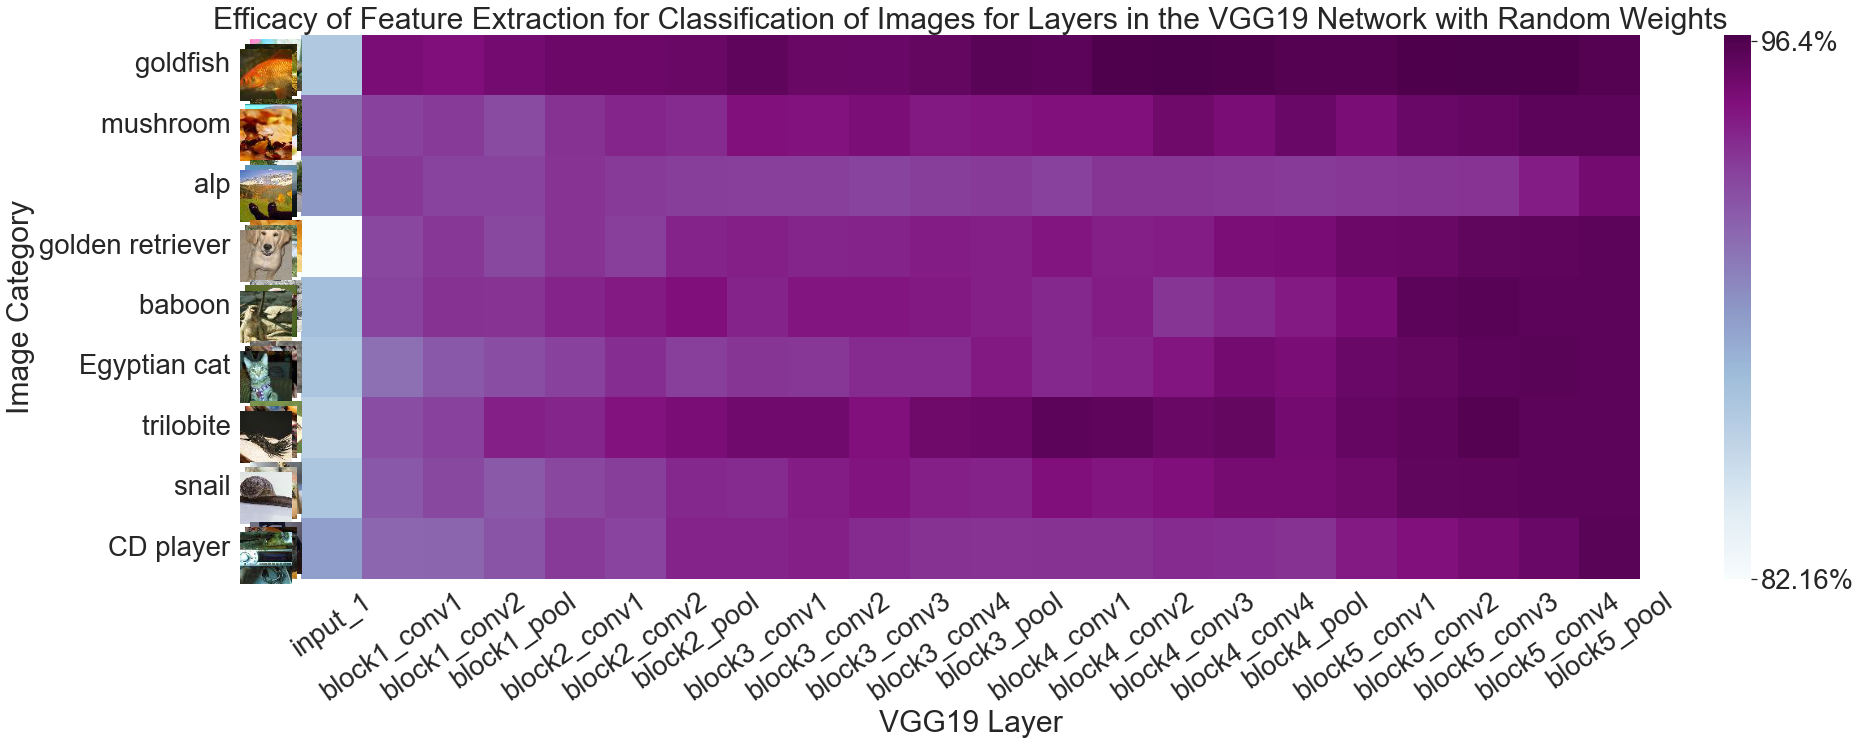

<Figure size 432x288 with 0 Axes>

In [27]:
#make heatmap visual
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns
import os
from matplotlib.offsetbox import (TextArea, DrawingArea, OffsetImage,
                                  AnnotationBbox)

plt.figure(figsize=(30, 10)) # width and height in inches

lst = ['{0}        '.format(elem) for elem in names_of_categories]



ax = sns.heatmap(heatmap_data, yticklabels=lst, cmap="BuPu")
sns.set_theme()

image_path = os.listdir("plot_images")
image_path.remove('.DS_Store')
image_path.sort()
print(image_path)
img = [plt.imread("plot_images/" + image) for image in image_path]

ax = plt.gca()
sns.set(font_scale = 2.5)
plt.title("Efficacy of Feature Extraction for Classification of Images for Layers in the VGG19 Network with Random Weights")
y_tick_labels = ax.yaxis.get_ticklabels()

ax.set_xticklabels(['input_1', 'block1_conv1', 'block1_conv2', 'block1_pool', 'block2_conv1', 'block2_conv2', 'block2_pool', 'block3_conv1', 'block3_conv2', 'block3_conv3', 'block3_conv4', 'block3_pool', 'block4_conv1', 'block4_conv2', 'block4_conv3', 'block4_conv4', 'block4_pool', 'block5_conv1', 'block5_conv2', 'block5_conv3', 'block5_conv4', 'block5_pool'])
plt.xticks(rotation = 35)

ax.set_xlabel('VGG19 Layer')
ax.set_ylabel('Image Category')

category_batch_size = 3
for i in range(0, 9):
  for j in range(0, category_batch_size):
    ib = OffsetImage(img[i*3+j], zoom=.8)
    ib.image.axes = ax
    ab = AnnotationBbox(ib,
                        y_tick_labels[i].get_position(),
                        frameon=False,
                        box_alignment=(1 + (j*0.1), .5 + (j*0.1)),
                        bboxprops =dict(edgecolor='white'  )
                        )
    ax.add_artist(ab)
  for j in range(0, category_batch_size):
    ib = OffsetImage(img[i*3+j], zoom=.8)
    ib.image.axes = ax
    ab = AnnotationBbox(ib,
                        y_tick_labels[i].get_position(),
                        frameon=False,
                        box_alignment=(1 + (j*0.1), .5 + (j*0.1)),
                        bboxprops =dict(edgecolor='white' )
                        )
    ax.add_artist(ab)

cbar = ax.collections[0].colorbar
cbar.set_ticks([0.8216, 0.964])
cbar.set_ticklabels(['82.16%', '96.4%'])

plt.show()

plt.savefig("heatmap.png",bbox_inches='tight')

In [22]:
# logisticRegression = sklearn.linear_model.LogisticRegression(solver='liblinear', random_state=0)
# logisticRegression.fit(log_input, log_output)
# logisticRegression.classes_

In [23]:
# print(len(val_images))
# logisticRegression.predict(val_images)